To kick off <a href=blogging-blitz-2019.html> the blitz </a> I'm going to begin with an idea I had back in April of this year which I think could be a lot of fun to play with but which I don't feel like I have had enough time to get a real feel for. The idea is in essence "why not replace all the dense layers in a neural network with convolutional layers?".

<!-- TEASER_END -->

I often find making adjustments to dense network layers to be more frustrating than dealing with convolutional layers in a network. If I want to adjust the execution memory footprint, the computational burden of the network, or increase or decrease the number of parameters in the network a little I will usually be able to find a way to get what close to exactly what I want somewhere in the huge design space of kernel sizes, number of channels, convolution strides, pooling types, pooling strides, mixed kernels, etc, etc. 

The comparative paucity of design choices to be made with a stack of dense layers sometimes leaves me in situations where my network is under performant or overly resource hungry (or both) and I find it is much more difficult to make adjustments to a dense network architecture to address these problems than when dealing with a convolutional network. 


## A little theoretical motivation

The big reason that dense networks are relatively inflexible is that the transform complexity (in terms of number of parameters) is rigidly tied to the amount of computation and amount of memory required. A dense layer with M input activations and N output activations needs $M*N$ free parameters and also takes $M*N$ multiply-adds worth of computation. 

By contrast consider the transform represented by a 2D convolutional layer which takes an input activation space of $N_1 x N_2 x C_1$ and transforms it to an activation space with the same spatial footprint but a different number of channels $N_1 x N_2 x C_2$. The number of parameters involved depends on the kernel width $K$ which is typically very small $K\approx3$ and for a 2D kernel with equal kernel widths in each dimension the number of parameters controlling the complexity of the convolutional transform is just $K^2 x C_1 x C_2$. Whereas the amount of computation is proportional to the product of the number of input activations and number of convolution parameters $N_1*N_2*K^2*C_1*C_2$.  

In practice this means that the computational burden of a convolutional net is dominated by the spatial size of the activation maps (and in turn can be controlled by the aggressiveness of your pooling strategy) and the overal network complexity (in terms of numbers of parameters at least) is controlled by the kernel sizes. This makes computation cost and transform complexity much more loosely coupled in convolution nets than in dense nets and gives the practioner more freedom.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as L

In [2]:
%matplotlib inline
plt.rcParams.update(
    {
        "figure.figsize":(12, 6),
        "font.size":16,
    }
)

# Toy Problem: Permuted CIFAR-100

As a play ground for these ideas I want a problem with a large number of input features and for which you might normally use a dense network. I wanted a problem with a fair amount of data and thousands of features and no spatial structure.

Instead of hunting down a data set with no intrinsic spatial structure, I just decided to grab an image dataset and destroy the spatial structure by applying a random permutation to the feature map.

In [3]:
(xtrain, ytrain), (xtest, ytest) = keras.datasets.cifar100.load_data()

xtrain = xtrain/255.0 - 0.5
xtest = xtest/255.0 - 0.5

n_categories = len(np.unique(ytrain))
orig_shape = xtrain.shape[1:]

#onehot encode the labels
ytrain_oh = keras.utils.to_categorical(ytrain, n_categories)
ytest_oh = keras.utils.to_categorical(ytest, n_categories)

#flatten the features
xtrain = xtrain.reshape((len(xtrain), -1))
xtest = xtest.reshape((len(xtest), -1))

n_features = xtrain.shape[-1]

#apply a permutation to destroy the spatial structure
data_perm = np.random.RandomState(seed=1234321).permutation(n_features)
xtrain = xtrain[:, data_perm]
xtest = xtest[:, data_perm]

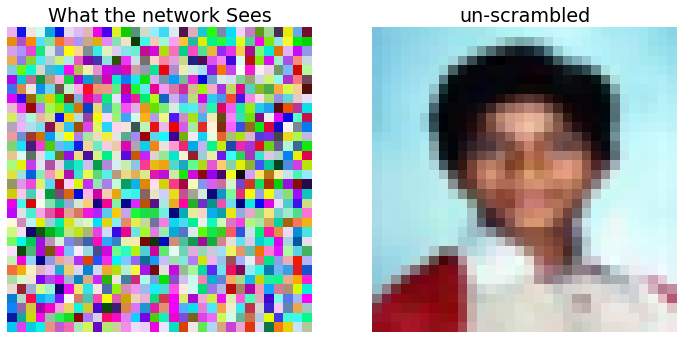

In [4]:
fig, axes = plt.subplots(1, 2)

example_idx = 3

axes[0].imshow(xtrain[example_idx].reshape(orig_shape)+0.5)
axes[0].set_title("What the network Sees")

inverse_perm = np.argsort(data_perm)

axes[1].imshow(xtrain[example_idx][inverse_perm].reshape(orig_shape)+0.5)
axes[1].set_title("un-scrambled")

for ax in axes:
    ax.axis("off")

As you can see after the permutation there is no longer really any clear concept of "local features" for a convolutional network to take advantage of. 

# A Dense Network Solution

Treating these 3072 input values as undifferentiated features and feeding them through a dense feed forward network I can manage to get about 28% accuracy over the 100 different classes. CIFAR-100 is a pretty challenging data set and even with some data augmentation and heavily tuned 2D convolutional architectures it can be <a href=https://benchmarks.ai/cifar-100> hard to get above 80% accuracy </a>. After destroying the spatial structure of the images all together it seems reasonable that performance would plummet. My goal however is not to reach "state of the art" permuted cifar-100 performance, it is just to give me a baseline for what a little architecture tuning using a dense network tool-kit might look like for this problem, both in terms of performance and model complexity. 

Perhaps a dozen iterations on the network architecture left me with the design below, with around 4.5 million parameters. I can easily make a more parsimonious network (parameter wise) but I couldn't get as high of performance out of networks without at least a few million parameters. 

In [5]:
def baseline_dense_model():
    x_in = L.Input((n_features,))
    x = x_in
    x = L.Dense(1024, activation="relu")(x)
    x = L.Dropout(0.4)(x)
    x = L.Dense(1024, activation="relu")(x)
    x = L.Dropout(0.4)(x)
    x = L.Dense(256, activation="relu")(x)
    x = L.Dense(n_categories, activation='softmax')(x)
    return keras.models.Model(x_in, x)

baseline_model = baseline_dense_model()
baseline_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [6]:
baseline_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              3146752   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_3 (Dense)              (None, 100)               25700 

In [7]:
training_kwargs = dict(
    batch_size=256,
    epochs=50,
    verbose=False,
)

In [8]:
baseline_training = baseline_model.fit(
    xtrain, ytrain_oh, 
    validation_data=(xtest, ytest_oh),
    **training_kwargs
)

In [9]:
def plot_training_curves(
    keras_history,
    target="accuracy",
    plot_train=True,
    plot_validation=True,
    ax=None,
):
    if ax is None:
        fig, ax = plt.subplots()

    values = keras_history.history[target]
    epochs = np.arange(1, len(values)+1)
    
    if plot_train:
        ax.plot(epochs, values)
    
    if plot_validation:
        validation_values = keras_history.history["val_" + target]
        ax.plot(epochs, validation_values)

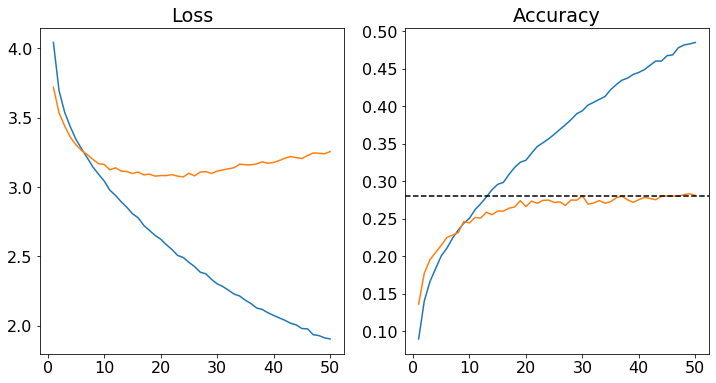

In [10]:
fig, axes = plt.subplots(1, 2)
axes[0].set_title("Loss")
axes[1].set_title("Accuracy")
plot_training_curves(baseline_training, target="loss", ax=axes[0])
plot_training_curves(baseline_training, target="accuracy", ax=axes[1])
axes[1].axhline(0.28, linestyle="--", color="k");

# Permutation-CNN

So how can we bring the tool-kit of convolutional network stacks to bear on a set of activations with no spatial dimensions? 

The obvious answer is just reshape the features from shape (M,) to have a faux spatial dimension and look like a spatial feature map of shape (M//k, k). The fact that the features in each spatial position are no more closely related to each other than any other features is probablematic from a semantic perspective. Since the CNN is learning "local" features but any sense of locality is entirely arbitrary. But there is no reason that such a network can't learn to extract useful information and for the reasons noted at the start of this post the use of convolutions instead of dense transforms will help to decouple the parameter complexity of the network from the size of the feature maps.

But there is a problem with just using a regular stack of convolutions to build out our feature maps. Convolutions tend to spread spatial information only fairly slowly (though there are tricks like dialated convolutions). But certain features might be valuable only if we have access to the values of other features which are "far away" in the particular feature map we have chosen. Since the adjacency in the faux spatial dimension is entirely arbitrary anyway we can randomly shuffle the spatial dimension before each convolution. This gives features which were distant in earlier feature maps the chance to interact with each other.

Here is a helper function to apply random permutations to tensors with 1 batch, 1 spatial, and 1 channel dimension.

In [11]:
def permute_1D_with_channels(
    tensor_in, 
    permutation=None, 
    permutation_seed=None,
):
    x_shape_in = tensor_in.shape.as_list()
    assert len(x_shape_in) == 3
    
    n_batch, n_spatial, n_channels = x_shape_in
    
    if permutation is None:
        permutation = np.random.RandomState(seed=permutation_seed).permutation(n_spatial)
    
    permuted = keras.layers.Lambda(lambda x: tf.gather(x, indices=permutation, axis=1))(tensor_in)
    return permuted


and here is a simple architecture with 1D convolutions interspersed with random permutations. 

In [12]:
def build_permutation_model():
    x_in = keras.layers.Input((n_features,))
    x = x_in
    x = L.Reshape((n_features//64, 64))(x)
    
    x = L.Conv1D(64, 5, strides=2, activation="relu", padding="same")(x)
    x = permute_1D_with_channels(x)
    
    x = L.Dropout(0.25)(x)
    
    x = L.Conv1D(64, 5, strides=2, activation="relu", padding="same")(x)
    x = permute_1D_with_channels(x)
    
    x = L.Conv1D(64, 5, strides=3, activation="relu", padding="same")(x)
    
    x = L.Dropout(0.2)(x)
    
    x = L.Flatten()(x)
    x = L.Dense(n_categories, activation="softmax")(x)

    return keras.models.Model(x_in, x)


perm_model = build_permutation_model()

perm_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [13]:
perm_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
reshape (Reshape)            (None, 48, 64)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 24, 64)            20544     
_________________________________________________________________
lambda (Lambda)              (None, 24, 64)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 12, 64)            20544     
_________________________________________________________________
lambda_1 (Lambda)            (None, 12, 64)            0   

In [14]:
perm_training = perm_model.fit(
    xtrain, ytrain_oh, 
    validation_data=(xtest, ytest_oh),
    **training_kwargs
)

In [17]:
perm_model.evaluate(xtest, ytest_oh, verbose=False)

[3.093251454925537, 0.27]

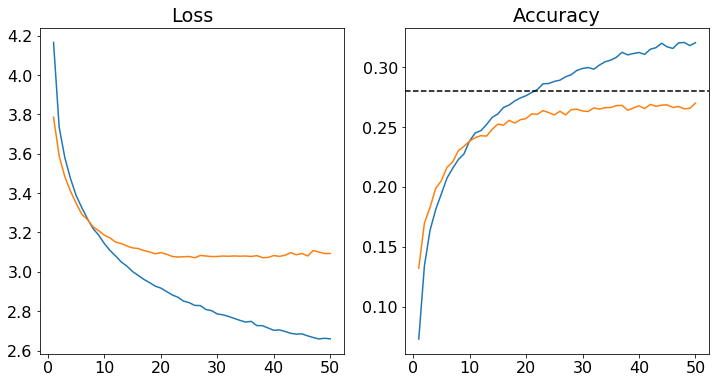

In [15]:
fig, axes = plt.subplots(1, 2)
axes[0].set_title("Loss")
axes[1].set_title("Accuracy")
plot_training_curves(perm_training, target="loss", ax=axes[0])
plot_training_curves(perm_training, target="accuracy", ax=axes[1])
axes[1].axhline(0.28, linestyle="--", color="k")

As you can see the random permutation network trains up to about 26% accuracy. While that is still quite a bit shy of the 28% accuracy that we can squeeze out of a mildly tuned dense network it isn't completely off the mark.  But what is remarkable is how few parameters the network required to get there. Just 90,000 parameters! Fewer than 1/50th the number of parameters used by the dense network above. In fact many fewer parameters than the 300,000 parameters that a direct linear model (e.g. logistic regression) would have used!.

# Multiple Initial Permutations

One problem with the above approach is that the choice of features are stuck together into pseudo-spatial features when we do the feature reshaping is entirely arbitrary and has a strong effect on the model. Some features belonging to the same or nearby pixels will happen to get randomly assigned to a pseudo-spatial block together and other pairs will be assigned far away and will therefore won't be able to combine their information into useful features until the later layers of the network.  

To help alleviate this problem I generate several different input feature permutations inside of the network prior to the pseudo-spatial reshaping, giving many different input feature pairs the chance to be close in at least one of the reshaped feature maps. Then I just reuse the same network structure as above as sub networks, then aggregate the results of each sub network just before prediction.


In [18]:
def build_multi_permutation_model():
    x_in = keras.layers.Input((n_features,))
    x = x_in
    
    x = L.Reshape((n_features, 1))(x)
    
    x1 = permute_1D_with_channels(x)
    x2 = permute_1D_with_channels(x)
    x3 = permute_1D_with_channels(x)
 
    x_out = []
    for x in [x1, x2, x3]:
        x = L.Reshape((n_features//64, 64))(x)
        x = L.Conv1D(64, 5, strides=2, activation="relu", padding="same")(x)
        x = permute_1D_with_channels(x)
        
        x = L.Dropout(0.25)(x)

        x = L.Conv1D(64, 5, strides=2, activation="relu", padding="same")(x)
        x = permute_1D_with_channels(x)

        x = L.Dropout(0.25)(x)
        
        x = L.Conv1D(128, 5, strides=3, activation="relu", padding="same")(x)

        x = L.GlobalMaxPooling1D()(x)
        
        x_out.append(x)
    
    x = L.concatenate(x_out)
    x = L.Dropout(0.25)(x)
    
    x = L.Dense(n_categories, activation="softmax")(x)

    return keras.models.Model(x_in, x)


In [19]:
mperm_model = build_multi_permutation_model()

mperm_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [20]:
mperm_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 3072)]       0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 3072, 1)      0           input_3[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 3072, 1)      0           reshape_1[0][0]                  
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 3072, 1)      0           reshape_1[0][0]                  
____________________________________________________________________________________________

In [21]:
mperm_training = mperm_model.fit(
    xtrain, ytrain_oh, 
    validation_data=(xtest, ytest_oh),
    **training_kwargs
)

In [22]:
mperm_model.evaluate(xtest, ytest_oh, verbose=False)

[2.9847203704833984, 0.2875]

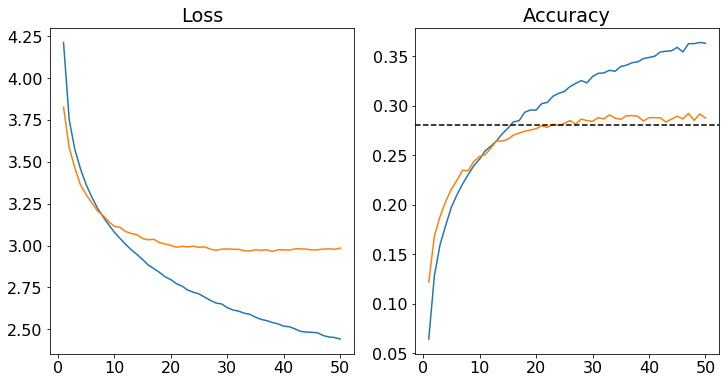

In [23]:
fig, axes = plt.subplots(1, 2)
axes[0].set_title("Loss")
axes[1].set_title("Accuracy")
plot_training_curves(mperm_training, target="loss", ax=axes[0])
plot_training_curves(mperm_training, target="accuracy", ax=axes[1])
axes[1].axhline(0.28, linestyle="--", color="k")

This network manages to outperform our baseline dense network, even though this model still has fewer parameters than a direct linear classifier would! 

# Thoughts

So should people all start replacing the dense layers in their networks with permutation-cnn stacks? I would have to say no, or at least not the way I have done it here. At the beginning of the post I talked about how much more rich the configuration space of a convolutional network stack is than for dense networks. In the case of data with real spatial or temporal structure it is possible to reason about what a particular pooling strategy is really doing what sort of features it enables etc. This ability to reason about the network structure and how it interacts with the data is entirely missing in the new faux spatial permutation-cnn. 

Without that intuition about the nature of the data the architecture choices become more or less blind hyper parameter tuning in a huge design space. The above permutation network works significantly better with kernel size 5 than 3, and works better when the input data is shaped to be initially 1D with 64 channels than it does with say 32 channels which in turn is better than starting with a single channel with every input feature getting its own pseudo-spatial position assignment. 

In general if you can squeeze only tiny bit of extra performance out of a class of models with a huge hyper-parameter search space then you are definitely better off going with something with either a small number of hyper-parameters or a model which performs well without having to do much tuning. Although the dense network isn't exactly the sort of model which doesn't need much tuning it is still significantly easier to tune than the permutation-cnn turned out to be.

The one place where the permutation-cnn really did shine here is in terms of how few parameters are needed by the network. I could easily envision situations where you might be willing to take a hit in performance in order to get a 10x-50x reduction in the model size. But I am afraid somewhat that the small performance hit and huge parameter reduction that we saw in this case is due to the fact that most of our input features were the same type of feature. This allowed the parameter sharing induced by the use of convolutional transforms instead of full linear transforms to perform well, and in other contexts I would be afraid that they might perform more poorly. 

It definitely feels like there is something here, it feels like there should be some sort of middle ground between the large adaptable configuration space of convolutional networks with their low parameter counts and decoupled computation cost and parameter complexity, and the simpler configuration space of dense networks and their rapidly exploding parameter complexity. A good way to achieve that middle ground might not be permutation-cnn as I have played with them here. But, it does seem like there is something interesting here and I feel like there is lots of room to explore.